# Assignment 3 - Building a Custom Visualization

---

In this assignment you must choose one of the options presented below and submit a visual as well as your source code for peer grading. The details of how you solve the assignment are up to you, although your assignment must use matplotlib so that your peers can evaluate your work. The options differ in challenge level, but there are no grades associated with the challenge level you chose. However, your peers will be asked to ensure you at least met a minimum quality for a given technique in order to pass. Implement the technique fully (or exceed it!) and you should be able to earn full grades for the assignment.


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Ferreira, N., Fisher, D., & Konig, A. C. (2014, April). [Sample-oriented task-driven visualizations: allowing users to make better, more confident decisions.](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/Ferreira_Fisher_Sample_Oriented_Tasks.pdf) 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In Proceedings of the SIGCHI Conference on Human Factors in Computing Systems (pp. 571-580). ACM. ([video](https://www.youtube.com/watch?v=BI7GAs-va-Q))


In this [paper](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/Ferreira_Fisher_Sample_Oriented_Tasks.pdf) the authors describe the challenges users face when trying to make judgements about probabilistic data generated through samples. As an example, they look at a bar chart of four years of data (replicated below in Figure 1). Each year has a y-axis value, which is derived from a sample of a larger dataset. For instance, the first value might be the number votes in a given district or riding for 1992, with the average being around 33,000. On top of this is plotted the 95% confidence interval for the mean (see the boxplot lectures for more information, and the yerr parameter of barcharts).

<br>
<img src="readonly/Assignment3Fig1.png" alt="Figure 1" style="width: 400px;"/>
<h4 style="text-align: center;" markdown="1">  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Figure 1 from (Ferreira et al, 2014).</h4>

<br>

A challenge that users face is that, for a given y-axis value (e.g. 42,000), it is difficult to know which x-axis values are most likely to be representative, because the confidence levels overlap and their distributions are different (the lengths of the confidence interval bars are unequal). One of the solutions the authors propose for this problem (Figure 2c) is to allow users to indicate the y-axis value of interest (e.g. 42,000) and then draw a horizontal line and color bars based on this value. So bars might be colored red if they are definitely above this value (given the confidence interval), blue if they are definitely below this value, or white if they contain this value.


<br>
<img src="readonly/Assignment3Fig2c.png" alt="Figure 1" style="width: 400px;"/>
<h4 style="text-align: center;" markdown="1">  Figure 2c from (Ferreira et al. 2014). Note that the colorbar legend at the bottom as well as the arrows are not required in the assignment descriptions below.</h4>

<br>
<br>

**Easiest option:** Implement the bar coloring as described above - a color scale with only three colors, (e.g. blue, white, and red). Assume the user provides the y axis value of interest as a parameter or variable.


**Harder option:** Implement the bar coloring as described in the paper, where the color of the bar is actually based on the amount of data covered (e.g. a gradient ranging from dark blue for the distribution being certainly below this y-axis, to white if the value is certainly contained, to dark red if the value is certainly not contained as the distribution is above the axis).

**Even Harder option:** Add interactivity to the above, which allows the user to click on the y axis to set the value of interest. The bar colors should change with respect to what value the user has selected.

**Hardest option:** Allow the user to interactively set a range of y values they are interested in, and recolor based on this (e.g. a y-axis band, see the paper for more details).

---

*Note: The data given for this assignment is not the same as the data used in the article and as a result the visualizations may look a little different.*

In [31]:
# Use the following data for this assignment:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbs

%matplotlib notebook

np.random.seed(12345)

df = pd.DataFrame([np.random.normal(32000,200000,3650), 
                   np.random.normal(43000,100000,3650), 
                   np.random.normal(43500,140000,3650), 
                   np.random.normal(48000,70000,3650)], 
                  index=[1992,1993,1994,1995])


In [2]:
from scipy import stats
year_avg = df.mean(axis = 1)
year_std = df.std(axis = 1)
yerr = year_std / np.sqrt(df.shape[1]) * stats.t.ppf(1-0.05/2, df.shape[1]-1)


threshold = 42000


In [3]:
import matplotlib.colors as mcol
import matplotlib.cm as cm

<IPython.core.display.Javascript object>


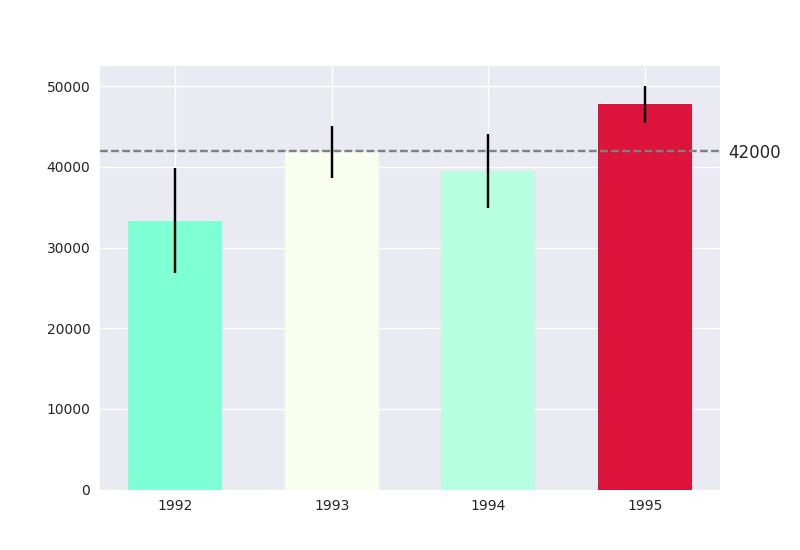

In [33]:
xvals = range(len(year_avg))

cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",['aquamarine', 'ivory', 'crimson'])
cpick = cm.ScalarMappable(cmap=cm1)
cpick.set_array([])


fig = plt.figure()


percentages  = []
for height, yerr_ in zip(year_avg, yerr):
    low = height - yerr_
    high = height + yerr_
    percentage = (high-threshold)/(high-low)
    if percentage>1: percentage = 1
    if percentage<0: percentage=0
    percentages.append(percentage)

    
    
bars = plt.bar(xvals,year_avg,yerr=yerr,width=0.6,color=cpick.to_rgba(percentages))

for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tick_params(left='off',bottom='off')
plt.xticks(xvals,year_avg.index.values)

line = plt.gca().axhline(y=threshold,color='grey',ls='--')  
annotate = plt.annotate(str(threshold),(plt.gca().get_xlim()[1],threshold-700),xytext=(plt.gca().get_xlim()[1]+0.05,threshold-(0.02*threshold)))
plt.show()



class DraggableRectangle:
    def __init__(self, rect):
        self.rect = rect
        self.press = None
        
    def connect(self):
        
        'connect to all the events we need'
        self.cidpress = self.rect.canvas.mpl_connect(
            'button_press_event', self.on_press)
        self.cidrelease = self.rect.canvas.mpl_connect(
            'button_release_event', self.on_release)
        self.cidmotion = self.rect.canvas.mpl_connect(
            'motion_notify_event', self.on_motion)
        
    def on_press(self, event):
        'on button press we will see if the mouse is over us and store some data'
        if event.inaxes != self.rect.gca(): return
        contains, attrd = self.rect.contains(event)
        if not contains: return
        self.press = event.xdata, event.ydata
        threshold = event.ydata
        line.set_ydata(threshold-(0.02*threshold))
        annotate.set_y(threshold-(0.02*threshold))
        annotate.set_text(int(round(threshold)))
        
    def on_motion(self, event):
        if self.press is None: return
        if event.inaxes != plt.gca(): return
        threshold = event.ydata
        line.set_ydata(threshold)
        annotate.set_y(threshold-(0.02*threshold))
        annotate.set_text(int(round(threshold)))

    def on_release(self, event):
        'on release we reset the press data'
        self.press = None
        threshold = event.ydata
        percentages = []
        for height, yerr_ in zip(year_avg, yerr):
            low = height - yerr_
            high = height + yerr_
            percentage = (high-threshold)/(high-low)
            if percentage>1: percentage = 1
            if percentage<0: percentage=0
            percentages.append(percentage)
            
        
        for bar,percentage in zip(bars,cpick.to_rgba(percentages)):
            bar.set_color(percentage)
       
        self.rect.canvas.draw()
 
    def disconnect(self):
        'disconnect all the stored connection ids'
        self.rect.figure.canvas.mpl_disconnect(self.cidpress)
        self.rect.figure.canvas.mpl_disconnect(self.cidrelease)
        self.rect.figure.canvas.mpl_disconnect(self.cidmotion)


fig = DraggableRectangle(fig)
fig.connect()